# Racing Line Calculation Worksheet

Inspired by the paper [Reinforcement Learning Using Neural Networks, with Applications to Motor Control
](https://www.remi-coulom.fr/Publications/Thesis.pdf), which is referenced by a number of machine learning articles, we calculate a race line around a simple race track.

#### New notebook

This notebook was forked from [this](https://github.com/cdthompson/deepracer-k1999-race-lines/blob/master/Race-Line-Calculation.ipynb) notebook by cdthompson.

This repo only contains the new notebook, not the entire directory. So make sure to download the entire directory from cdthompson's repo.

In [18]:
import glob
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import pandas as pd
import matplotlib.pyplot as plt
import os.path

In [19]:
# Hyperparams to be adjusted based on track

# Update the track width based on percentage
PERC_WIDTH = 0.8

# Number of times to iterate each new race line point
# keep this at 3-8 for best balance of performance and desired result
XI_ITERATIONS = 4 # default 4

# Number of times to scan the entire race track to iterate
# 500 will get a good start, 1500 will be closer to optimal result
LINE_ITERATIONS = 2000 # default 1000


## Load the track to analyze

In [20]:
# Conveniently list available tracks to analyze
available_track_files = glob.glob("./tracks/**.npy")
available_track_names = list(map(lambda x: os.path.basename(x).split('.npy')[0], available_track_files))
available_track_names

['reinvent_base']

Is loop/ring?  True


/var/folders/k5/xrfxjccx5274x4q164gw0_t40000gn/T/ipykernel_41904/3819042701.py:14: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))
/Users/kewenyang/anaconda3/envs/pythonProject/lib/python3.10/site-packages/numpy/core/shape_base.py:286: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arrs = atleast_2d(*tup)


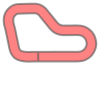

In [21]:
# Replace the name here with the track to analyze
TRACK_NAME = 'reinvent_base'

# Load the center, inner, outer waypoints
waypoints = np.load("tracks/reinvent_base.npy")

# Convert to Shapely objects
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))
print("Is loop/ring? ", l_center_line.is_ring)
road_poly

Is loop/ring?  True


/var/folders/k5/xrfxjccx5274x4q164gw0_t40000gn/T/ipykernel_41904/285908022.py:30: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  road_poly_new = Polygon(np.vstack((l_outer_border_new, np.flipud(l_inner_border_new))))


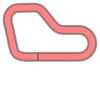

In [22]:
# Own code: Reduce width of track

def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5
    
def x_perc_width(waypoint, perc_width):
    
    center_x, center_y, inner_x, inner_y, outer_x, outer_y = waypoint
    
    width = dist_2_points(inner_x, outer_x, inner_y, outer_y)
    
    delta_x = outer_x-inner_x
    delta_y = outer_y-inner_y
    
    inner_x_new = inner_x + delta_x/2 * (1-perc_width)
    outer_x_new = outer_x - delta_x/2 * (1-perc_width)
    inner_y_new = inner_y + delta_y/2 * (1-perc_width)
    outer_y_new = outer_y - delta_y/2 * (1-perc_width)
    
    return [center_x, center_y, inner_x_new, inner_y_new, outer_x_new, outer_y_new]

waypoints_new = [x_perc_width(waypoint, perc_width=PERC_WIDTH) for waypoint in waypoints]
waypoints_new = np.asarray(waypoints_new)

# Convert to Shapely objects
inner_border_new = waypoints_new[:,2:4]
outer_border_new = waypoints_new[:,4:6]
l_inner_border_new = LineString(inner_border_new)
l_outer_border_new = LineString(outer_border_new)
road_poly_new = Polygon(np.vstack((l_outer_border_new, np.flipud(l_inner_border_new))))
print("Is loop/ring? ", l_center_line.is_ring)
road_poly_new

# Display the original track waypoints

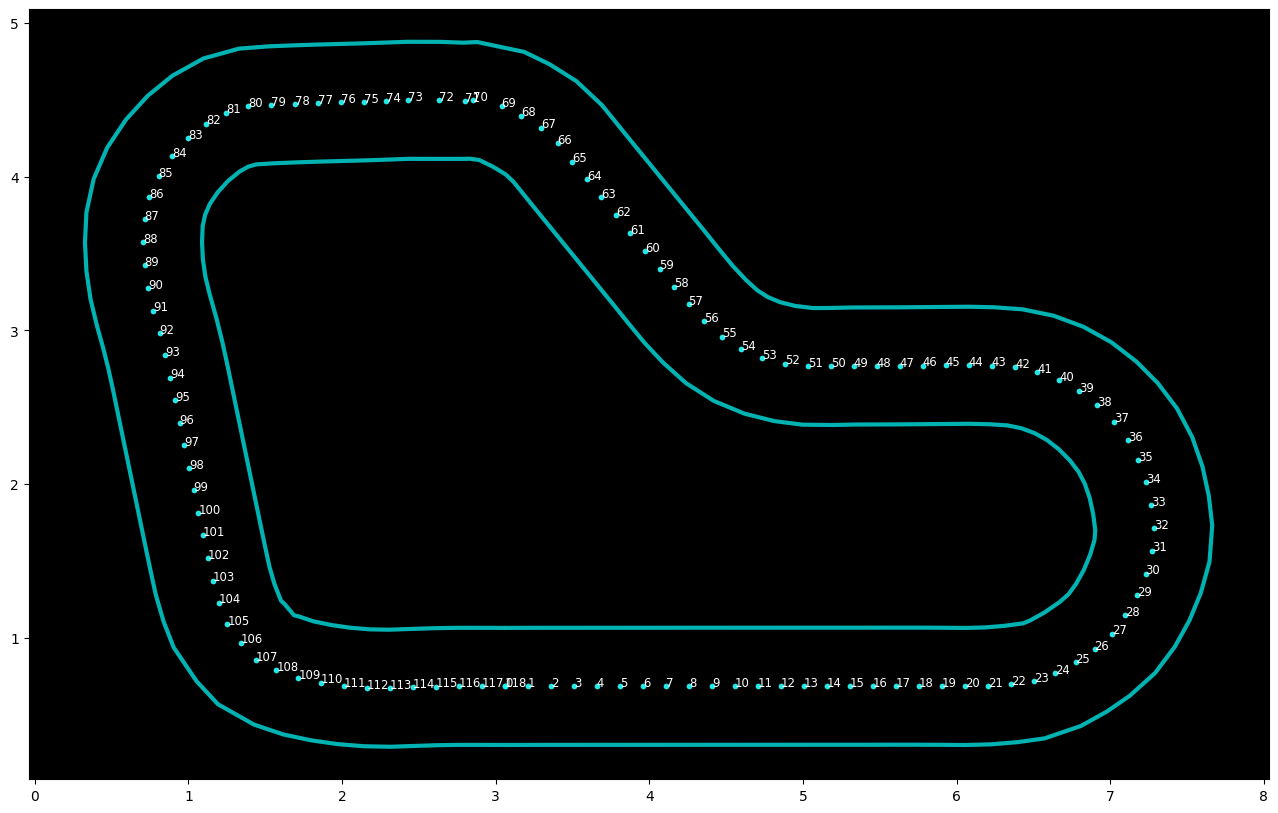

In [27]:
def plot_coords(ax, ob):                                                        
    x, y = ob.xy                                                                
    ax.plot(x, y, '.', color='#999999', zorder=1)    
    for index, (i_x, i_y) in enumerate(zip(x, y)):
        ax.text(i_x, i_y, f'{index}', color="white", size='small')                            
                                                                                
def plot_bounds(ax, ob):                                                        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))                          
    ax.plot(x, y, '.', color='#000000', zorder=1)                               
                                                                                
def plot_line(ax, ob, color='cyan', pt="-"):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, pt, color=color, alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
                                                                                            
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints, track=None):
    line = LineString(waypoints)                                                
    plot_coords(ax, line)                                                       
    plot_line(ax, line, pt=".")                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    # plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    # plot_coords(ax, line)                                                       
    plot_line(ax, line)   
    
    if track is None:
        return None
    
    for t in track:
        line = LineString(t)                                                
        plot_coords(ax, line)                                                       
        plot_line(ax, line, color="red", pt=".")    
        
    return None

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
# print_border(ax, center_line, inner_border, outer_border, track=[outer_border_new, inner_border_new])
print_border(ax, center_line, inner_border, outer_border)



In [24]:
# From https://github.com/e-koch/ewky_scripts/blob/master/curvature.py

# The MIT License (MIT)
#
# Copyright (c) 2014 Eric Koch
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def menger_curvature(pt1, pt2, pt3, atol=1e-3):

    vec21 = np.array([pt1[0]-pt2[0], pt1[1]-pt2[1]])
    vec23 = np.array([pt3[0]-pt2[0], pt3[1]-pt2[1]])

    # get the distance beween 21, and 23
    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)

    # get the angle between two distance
    theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))
    
    if np.isclose(theta-np.pi, 0.0, atol=atol):
        theta = 0.0

    # distance of the side
    dist13 = np.linalg.norm(vec21-vec23)

    return 2*np.sin(theta) / dist13

In [25]:
import copy
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

def improve_race_line(old_line, inner_border, outer_border):
    '''Use gradient descent, inspired by K1999, to find the racing line'''
    # start with the center line
    new_line = copy.deepcopy(old_line)
    ls_inner_border = Polygon(inner_border)
    ls_outer_border = Polygon(outer_border)
    for i in range(0,len(new_line)):
        print(f"when i is {i}")
        xi = new_line[i]
        npoints = len(new_line)
        prevprev = (i - 2 + npoints) % npoints
        prev = (i - 1 + npoints) % npoints
        nexxt = (i + 1 + npoints) % npoints
        nexxtnexxt = (i + 2 + npoints) % npoints
        print(f"the sequence of points are: {npoints}, {prevprev}, {prev}, {i}, {nexxt}, {nexxtnexxt}"))
        ci = menger_curvature(new_line[prev], xi, new_line[nexxt])
        c1 = menger_curvature(new_line[prevprev], new_line[prev], xi)
        c2 = menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])
        
        # take the average of two adjacent curvatures
        target_ci = (c1 + c2) / 2
        print("i %d ci %f target_ci %f c1 %f c2 %f" % (i, ci, target_ci, c1, c2))

        # Calculate prospective new track position, start at half-way (curvature zero)
        xi_bound1 = copy.deepcopy(xi)
        xi_bound2 = ((new_line[nexxt][0] + new_line[prev][0]) / 2.0, (new_line[nexxt][1] + new_line[prev][1]) / 2.0)
        p_xi = copy.deepcopy(xi)
        for j in range(0,XI_ITERATIONS):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])
            print("i: {} iter {} p_ci {} p_xi {} b1 {} b2 {}".format(i,j,p_ci,p_xi,xi_bound1, xi_bound2))
            if np.isclose(p_ci, target_ci):
                break
            if p_ci < target_ci:
                # too flat, shrinking track too much
                xi_bound2 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound1[0] + p_xi[0]) / 2.0, (xi_bound1[1] + p_xi[1]) / 2.0)
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound1 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
            else:
                # too curved, flatten it out
                xi_bound1 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound2[0] + p_xi[0]) / 2.0, (xi_bound2[1] + p_xi[1]) / 2.0)

                # If iteration pushes the point beyond the border of the track,
                # just abandon the refinement at this point.  As adjacent
                # points are adjusted within the track the point should gradually
                # make its way to a new position.  A better way would be to use
                # a projection of the point on the border as the new bound.  Later.
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound2 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
        new_xi = p_xi
        # New point which has mid-curvature of prev and next points but may be outside of track
        #print((new_line[i], new_xi))
        new_line[i] = new_xi
        break
    return new_line

SyntaxError: unmatched ')' (1035759751.py, line 19)

## Calculate the race line!

In [ ]:
print(len(center_line))

119


In [ ]:
race_line = copy.deepcopy(center_line[:-1])  # Use this for centerline being outer bound
race_line

array([[3.05973351, 0.68265541],
       [3.2095089 , 0.68313448],
       [3.35927546, 0.68336383],
       [3.50903499, 0.68340179],
       [3.658795  , 0.68346104],
       [3.80855501, 0.68351701],
       [3.95831501, 0.6835691 ],
       [4.10807562, 0.68362114],
       [4.25783491, 0.68367411],
       [4.40759492, 0.68372796],
       [4.55735493, 0.68378122],
       [4.70711446, 0.68383627],
       [4.85687399, 0.68389387],
       [5.00663304, 0.68395211],
       [5.15639353, 0.68400487],
       [5.30615449, 0.6840501 ],
       [5.45591187, 0.6841173 ],
       [5.60564542, 0.68433665],
       [5.7554214 , 0.6842881 ],
       [5.90530467, 0.68359549],
       [6.05528617, 0.68234065],
       [6.2049551 , 0.68616906],
       [6.3540616 , 0.69851732],
       [6.50251436, 0.71880828],
       [6.64373994, 0.76831104],
       [6.77488899, 0.84126708],
       [6.89846134, 0.92622706],
       [7.01003671, 1.02576673],
       [7.0997467 , 1.14608622],
       [7.17247367, 1.27703255],
       [7.

In [ ]:
# start along centerline of track
for i in range(LINE_ITERATIONS):
    race_line = improve_race_line(race_line, inner_border_new, outer_border_new)  # Remove "_new" for entire track width
    if i % 20 == 0: print("Iteration %d" % i, end="\r", flush=True)

i is 0
118: 116 117 0 1 2
i 0 ci 0.045312 target_ci 0.016925 c1 0.022718 c2 0.011132
i: 0 iter 0 p_ci 0.04531159398901628 p_xi [3.05973351 0.68265541] b1 [3.05973351 0.68265541] b2 (3.0597519278526306, 0.6831635162234306)
i: 0 iter 1 p_ci 0.02265599234592296 p_xi (3.059742718935013, 0.6829094626009464) b1 [3.05973351 0.68265541] b2 (3.0597519278526306, 0.6831635162234306)
i: 0 iter 2 p_ci 0.011328020592963148 p_xi (3.0597473233938217, 0.6830364894121885) b1 (3.059742718935013, 0.6829094626009464) b2 (3.0597519278526306, 0.6831635162234306)
i: 0 iter 3 p_ci 0.016992015626113997 p_xi (3.0597450211644173, 0.6829729760065675) b1 (3.059742718935013, 0.6829094626009464) b2 (3.0597473233938217, 0.6830364894121885)
i is 0ion 0
118: 116 117 0 1 2
i 0 ci 0.014160 target_ci 0.003569 c1 0.007138 c2 0.000000
i: 0 iter 0 p_ci 0.014160020017622926 p_xi [3.05974617 0.68300473] b1 [3.05974617 0.68300473] b2 (3.0597519278526306, 0.6831635162234306)
i: 0 iter 1 p_ci 0.007080015969708406 p_xi (3.059749050

These should be the same:  ((119, 2), (119, 2))
Original centerline length: 17.71
New race line length: 15.74


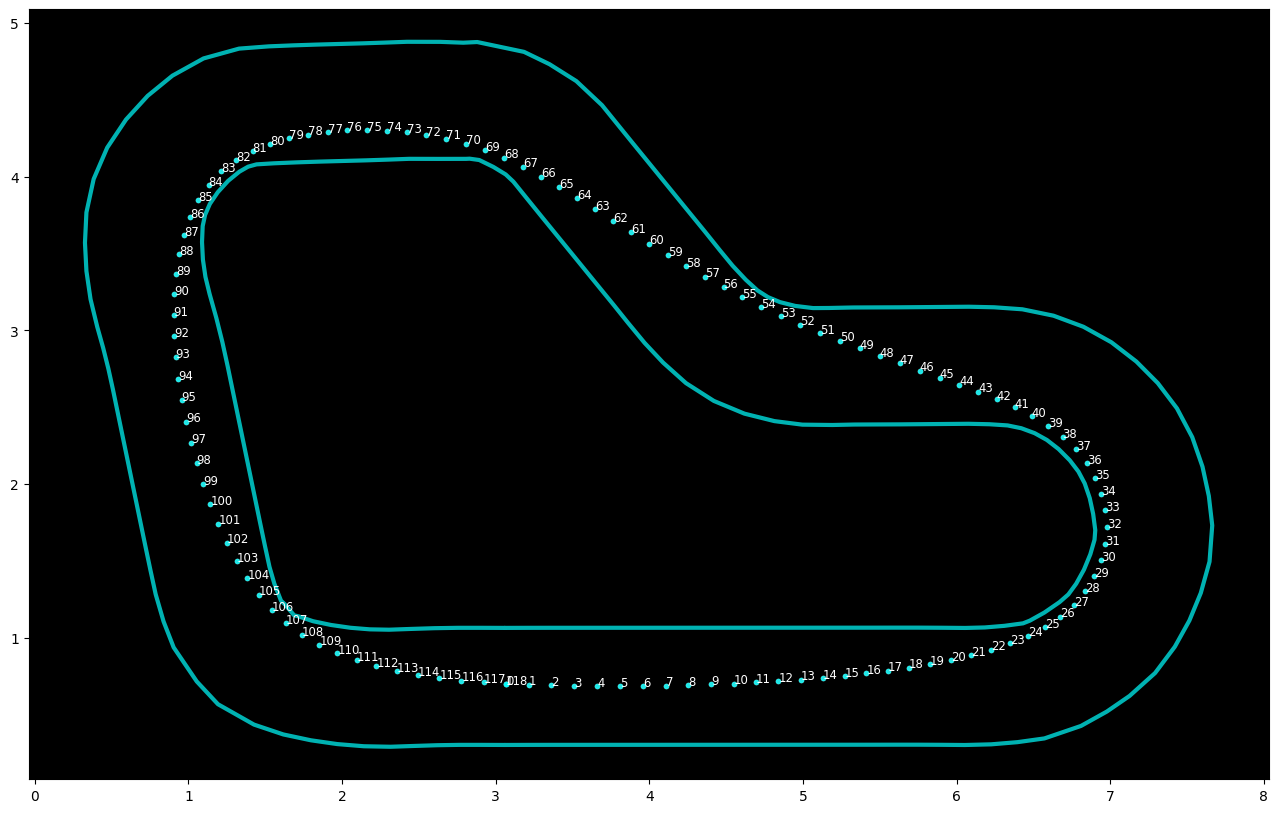

In [ ]:
# need to put duplicate point race_line[0] at race_line[-1] to make a closed loops
loop_race_line = np.append(race_line, [race_line[0]], axis=0)

# These should be the same
print("These should be the same: ", (center_line.shape, loop_race_line.shape))
print("Original centerline length: %0.2f" % l_center_line.length)
print("New race line length: %0.2f" % LineString(loop_race_line).length)

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, loop_race_line, inner_border, outer_border)

# Also print new border
#print_border(ax, loop_race_line, inner_border_new, outer_border_new)

## Save the raceline as:

1. Binary numpy array for loading from a file
2. Text numpy array for pasting directly into a reward function

In [ ]:
from datetime import datetime

now = datetime.now()
prefix = 'artifacts/raceline'
py_fname = prefix + '.py'
npy_fname = prefix + '.npy'
with open(py_fname, "w") as file:
    print("Writing python code to %s" % py_fname)
    file.write(np.array_repr(loop_race_line))
    
print("Writing numpy binary to %s" % npy_fname)
np.save(npy_fname, loop_race_line)

Writing python code to artifacts/raceline.py
Writing numpy binary to artifacts/raceline.npy


# Load and visualize a stored track file

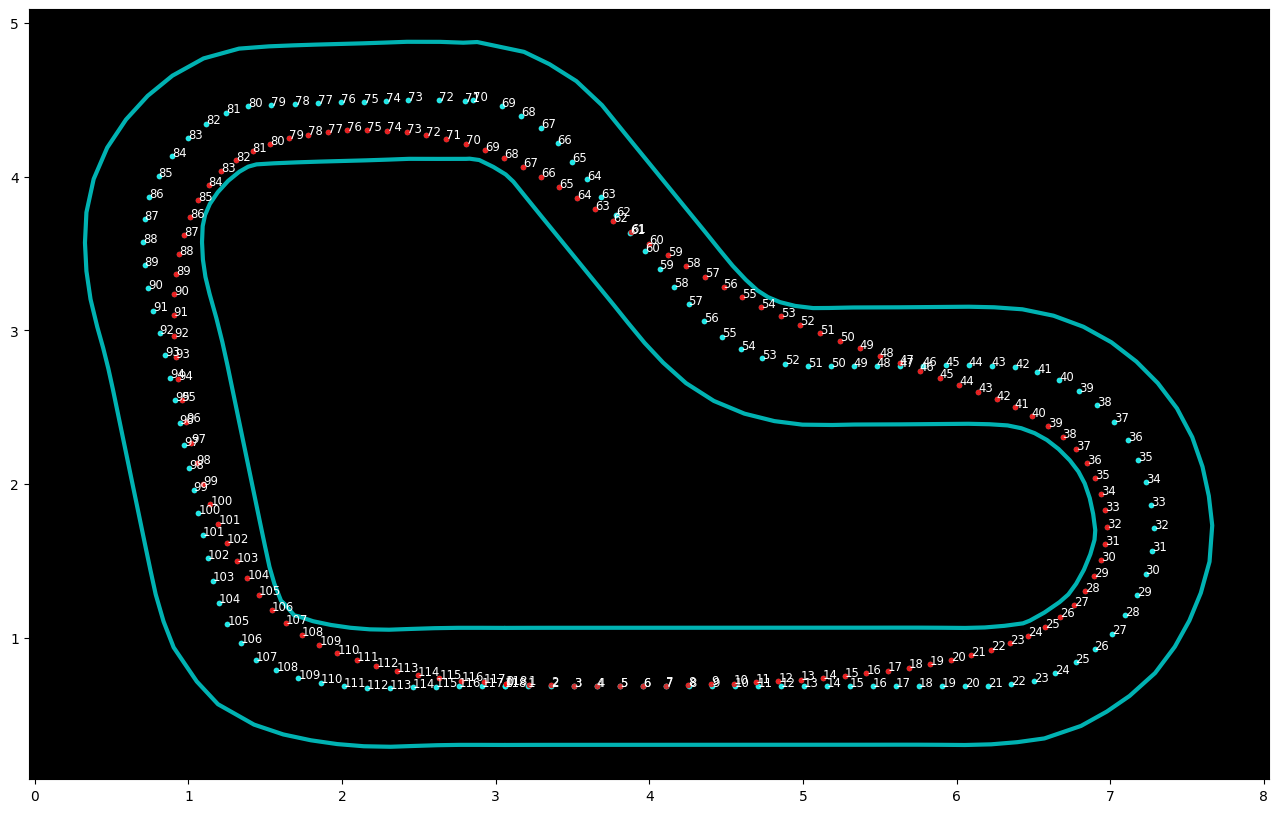

In [ ]:
from numpy import array

fname = 'artifacts/raceline.py'
with open(fname, "r") as file:
    deserialized = eval(file.read())
deserialized
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, center_line, inner_border, outer_border, track=[deserialized])

In [26]:
# observe which side the car is expected to run at
right_track = [47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
center_track = [118, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 47, 61]
left_track = [i for i in range(0, 119) if i not in right_track + center_track]

# obvious sides
strong_left = [
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
            65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
            102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        ]
strong_right = [49, 50, 51, 52, 53, 54, 55, 56, 57, 58]